# Earthquake Catalog Spatial Binning Analysis

This notebook provides a comprehensive analysis of different spatial binning methods for earthquake catalogs:
- **Quadtree Binning**: Adaptive spatial partitioning
- **Cartesian Grid**: Uniform spatial grid
- **Quadtree Validation**: Statistical optimization of parameters

## Features:
- Event distribution visualization
- Bin boundary analysis
- Statistical validation metrics
- Parameter optimization

In [1]:
# Install required packages
%pip install csep cartopy matplotlib pandas numpy

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement csep (from versions: none)
ERROR: No matching distribution found for csep


In [2]:
# Import libraries and setup paths
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pathlib import Path

# Setup project paths
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Import binning modules
from src.preprocessing.load_catalog import load_catalog
from src.binning.quadtree import apply_quadtree_binning, apply_quadtree
from src.binning.cartesian_grid import apply_cartesian

print("Libraries imported successfully")

Libraries imported successfully


In [3]:
# Load earthquake catalog
filepath = '../data/eq_catalog.csv'
df, original_catalog = load_catalog(filepath)

print(f"   Total events: {original_catalog.get_number_of_events()}")
print(f"   Latitude range: {original_catalog.get_latitudes().min():.1f}° to {original_catalog.get_latitudes().max():.1f}°")
print(f"   Longitude range: {original_catalog.get_longitudes().min():.1f}° to {original_catalog.get_longitudes().max():.1f}°")

   Total events: 3509
   Latitude range: 2.0° to 22.0°
   Longitude range: 116.3° to 133.0°


## 1. Unified Plotting Function

Single function to visualize any binning method with consistent styling and statistics.

In [4]:
def plot_binning_analysis(catalog, bounds, title, method_name, show_stats=True):
    """
    Plot binning results with consistent styling for both pandas DataFrame
    and pyCSEP Catalog objects.
    
    Args:
        catalog: Earthquake catalog (DataFrame or CSEP catalog)
        bounds: List of bin boundaries [(min_lon, max_lon, min_lat, max_lat), ...]
        title: Plot title
        method_name: Name of binning method
        show_stats: Whether to print bin statistics
    """
    import matplotlib.pyplot as plt
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature

    fig = plt.figure(figsize=(12, 10))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Set map extent
    ax.set_extent([116.3, 133.0, 2.0, 22.0], crs=ccrs.PlateCarree())

    # Add map features
    ax.coastlines(resolution='10m')
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.add_feature(cfeature.LAND, facecolor='lightgray', edgecolor='black', alpha=0.3)

    # --- Handle both DataFrame and CSEP Catalog ---
    if hasattr(catalog, 'get_longitudes'):
        # CSEP Catalog
        lons = catalog.get_longitudes()
        lats = catalog.get_latitudes()
        mags = catalog.get_magnitudes()
    else:
        # Pandas DataFrame
        lons = catalog['longitude'].values
        lats = catalog['latitude'].values
        mags = catalog['magnitude'].values

    # Plot earthquakes
    ax.scatter(lons, lats, s=mags**2, color='red', alpha=0.6, label='Earthquakes')

    # --- Plot bin boundaries and statistics ---
    if bounds:
        if show_stats:
            print(f"\n📦 BIN STATISTICS for {method_name}:")
            print("=" * 50)

        total_events = 0
        for i, (min_lon, max_lon, min_lat, max_lat) in enumerate(bounds, 1):
            # Draw bin rectangle
            rect = plt.Rectangle(
                (min_lon, min_lat),
                max_lon - min_lon,
                max_lat - min_lat,
                edgecolor='black',
                facecolor='none',
                linewidth=1,
                transform=ccrs.PlateCarree()
            )
            ax.add_patch(rect)

            # Count events in this bin
            in_bin = (
                (lons >= min_lon) & (lons < max_lon) &
                (lats >= min_lat) & (lats < max_lat)
            )
            event_count = in_bin.sum()
            total_events += event_count

            # Add event count label
            ax.text(
                (min_lon + max_lon) / 2,
                (min_lat + max_lat) / 2,
                str(event_count),
                ha='center', va='center',
                fontsize=8, color='black', weight='bold',
                transform=ccrs.PlateCarree()
            )

            if show_stats:
                print(f"Bin {i:2d}: Lon {min_lon:.2f}°-{max_lon:.2f}°, "
                      f"Lat {min_lat:.2f}°-{max_lat:.2f}°, Events: {event_count}")

        if show_stats:
            print(f"\n📊 Summary: {len(bounds)} bins, {total_events} total events")

    ax.set_title(f"{title}\n{method_name}", fontsize=14, fontweight='bold')
    ax.legend()
    plt.tight_layout()
    plt.show()

    return fig, ax


## 2. Cartesian Grid Binning

Uniform 3x3 spatial grid for baseline comparison.


📦 BIN STATISTICS for 3x3 Uniform Grid:
Bin  1: Lon 116.30°-121.87°, Lat 2.00°-8.67°, Events: 38
Bin  2: Lon 116.30°-121.87°, Lat 8.67°-15.33°, Events: 288
Bin  3: Lon 116.30°-121.87°, Lat 15.33°-22.00°, Events: 429
Bin  4: Lon 121.87°-127.43°, Lat 2.00°-8.67°, Events: 1395
Bin  5: Lon 121.87°-127.43°, Lat 8.67°-15.33°, Events: 934
Bin  6: Lon 121.87°-127.43°, Lat 15.33°-22.00°, Events: 133
Bin  7: Lon 127.43°-133.00°, Lat 2.00°-8.67°, Events: 274
Bin  8: Lon 127.43°-133.00°, Lat 8.67°-15.33°, Events: 12
Bin  9: Lon 127.43°-133.00°, Lat 15.33°-22.00°, Events: 4

📊 Summary: 9 bins, 3507 total events


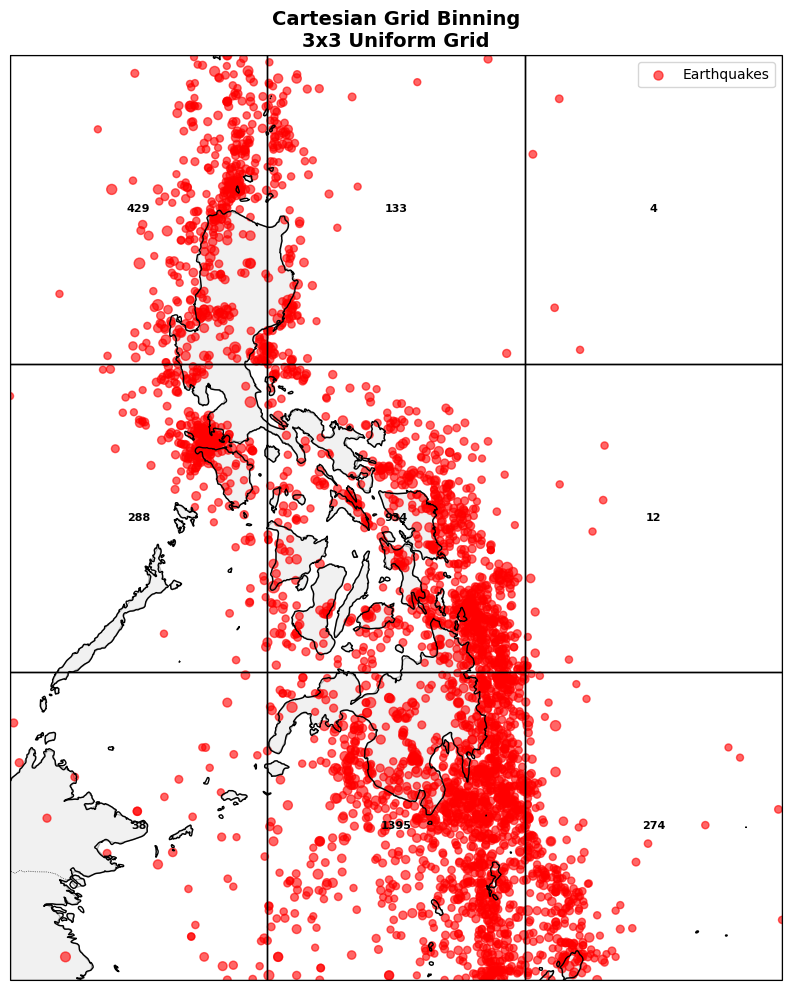

(<Figure size 1200x1000 with 1 Axes>,
 <GeoAxes: title={'center': 'Cartesian Grid Binning\n3x3 Uniform Grid'}>)

In [5]:
# Apply 3x3 Cartesian grid binning
filtered_grid, region_grid, bounds_grid = apply_cartesian(original_catalog)

# Visualize results
plot_binning_analysis(original_catalog, bounds_grid, "Cartesian Grid Binning", "3x3 Uniform Grid")

## 3. Quadtree Binning Analysis

Test different quadtree parameter combinations to find optimal settings.

Testing Quadtree Parameter Combinations:

🔍 Testing: Conservative (min_events=150, max_depth=2)


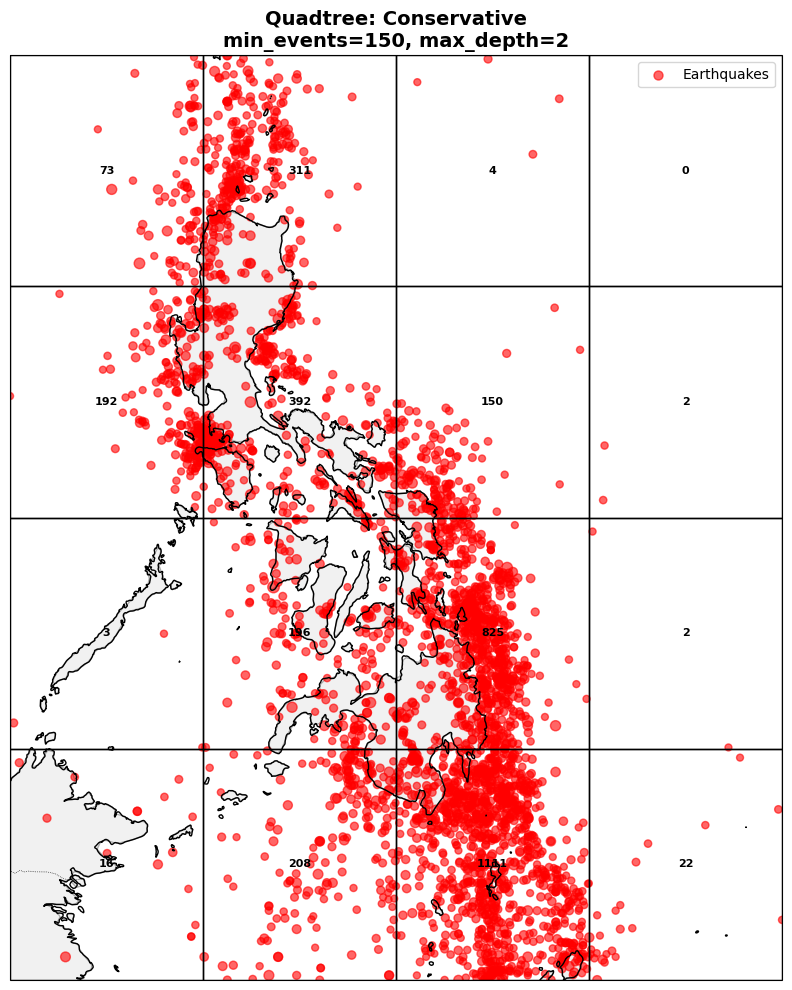

   Created 16 bins

🔍 Testing: Balanced (min_events=100, max_depth=3)


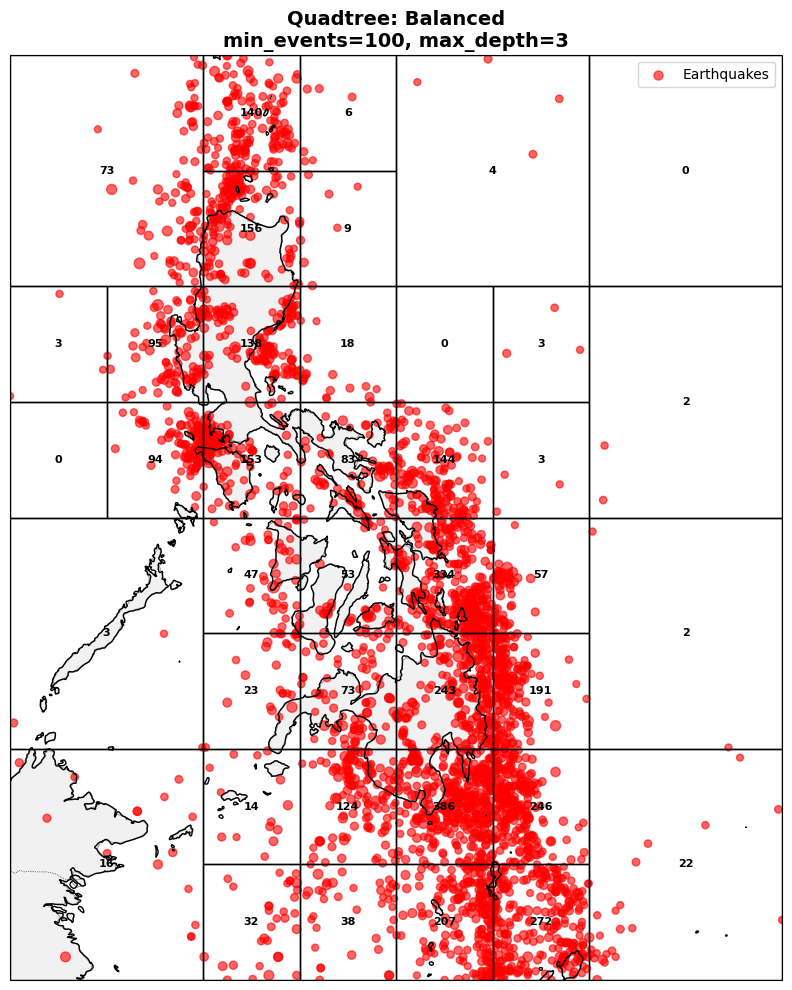

   Created 40 bins

🔍 Testing: Aggressive (min_events=50, max_depth=4)
   Created 100 bins

🔍 Testing: High Resolution (min_events=20, max_depth=5)
   Created 268 bins

🔍 Testing: Very High Resolution (min_events=10, max_depth=6)
   Created 664 bins


In [6]:
# Define parameter combinations to test
param_combinations = [
    {"label": "Conservative", "min_events": 150, "max_depth": 2},
    {"label": "Balanced", "min_events": 100, "max_depth": 3},
    {"label": "Aggressive", "min_events": 50, "max_depth": 4},
    {"label": "High Resolution", "min_events": 20, "max_depth": 5},
    {"label": "Very High Resolution", "min_events": 10, "max_depth": 6}
]

print("Testing Quadtree Parameter Combinations:")
print("=" * 60)

quadtree_results = {}

for params in param_combinations:
    label = params["label"]
    min_events = params["min_events"]
    max_depth = params["max_depth"]
    
    print(f"\n🔍 Testing: {label} (min_events={min_events}, max_depth={max_depth})")
    
    # Apply quadtree binning
    filtered, root, bounds = apply_quadtree(
        df,  # Use pandas DataFrame for this function
        min_events=min_events,
        max_depth=max_depth,
        min_bin_width=0.2
    )
    
    # Store results
    quadtree_results[label] = {
        'bounds': bounds,
        'min_events': min_events,
        'max_depth': max_depth,
        'num_bins': len(bounds)
    }
    
    # Visualize (show only first 2 for brevity)
    if label in ["Conservative", "Balanced"]:
        plot_binning_analysis(df, bounds, f"Quadtree: {label}", 
                             f"min_events={min_events}, max_depth={max_depth}", 
                             show_stats=False)
    
    print(f"   Created {len(bounds)} bins")




Final Bin Statistics:
Bin 0: 2.09° lon x 2.50° lat, 73 events
Bin 1: 2.09° lon x 2.50° lat, 386 events
Bin 2: 2.09° lon x 2.50° lat, 246 events
Bin 3: 2.09° lon x 2.50° lat, 243 events
Bin 4: 2.09° lon x 2.50° lat, 334 events
Bin 5: 2.09° lon x 2.50° lat, 57 events
Bin 6: 2.09° lon x 2.50° lat, 153 events
Bin 7: 2.09° lon x 2.50° lat, 138 events
Bin 8: 4.17° lon x 5.00° lat, 73 events
Bin 9: 6.26° lon x 5.00° lat, 62 events
Bin 10: 4.17° lon x 2.50° lat, 245 events
Bin 11: 4.18° lon x 2.50° lat, 138 events
Bin 12: 6.26° lon x 5.00° lat, 73 events
Bin 13: 4.18° lon x 2.50° lat, 100 events
Bin 14: 6.26° lon x 5.00° lat, 540 events
Bin 15: 6.26° lon x 5.00° lat, 250 events
Bin 16: 4.17° lon x 2.50° lat, 94 events
Bin 17: 4.17° lon x 2.50° lat, 98 events
Bin 18: 4.18° lon x 2.50° lat, 165 events
Bin 19: 4.18° lon x 2.50° lat, 146 events
Bin 20: 4.17° lon x 5.00° lat, 245 events
Bin 21: 8.35° lon x 10.00° lat, 156 events
Original catalog: 3509 events
Filtered catalog: 3507 events
Number of

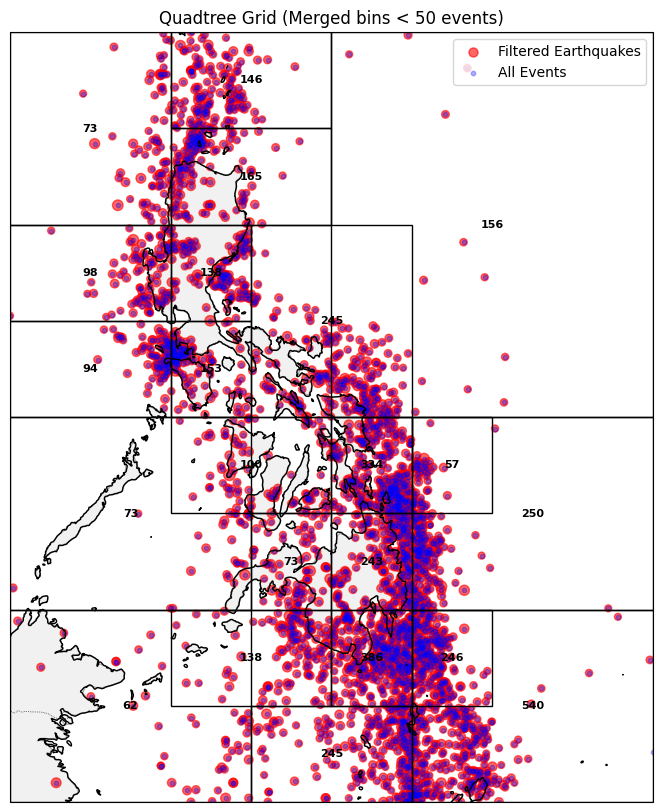

In [9]:
# --- Quadtree Binning with Merging ---

# Apply quadtree binning with aggressive merging
filtered_catalog, region, bounds = apply_quadtree_binning(
    original_catalog,
    max_depth=3,
    min_events=100,
    merge_threshold=50  # Merge bins with fewer than 50 events
)

print(f"Original catalog: {len(original_catalog.get_longitudes())} events")
print(f"Filtered catalog: {len(filtered_catalog.get_longitudes())} events")
print(f"Number of bins: {len(bounds)}")

# Plot the quadtree grid
from src.binning.quadtree import plot_quadtree_grid
plot_quadtree_grid(
    filtered_catalog,
    bounds,
    original_catalog,
    merge_threshold=50,
    show_bin_counts=True
)
